In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

#path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'
path_to_git = '/home/kentaro/github/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'cluster', 'sids', 'pseudoMRNs'])

In [4]:
iic_burden['sids'][865]

'sid1272'

In [5]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in tqdm.tqdm(range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in tqdm.tqdm(range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Effect of IIC Burden on Outcome

100%|██████████| 1323/1323 [00:04<00:00, 298.91it/s]

100%|██████████| 1323/1323 [00:04<00:00, 293.00it/s]

100%|██████████| 1323/1323 [00:04<00:00, 298.70it/s]

100%|██████████| 3/3 [41:21<00:00, 827.12s/it]


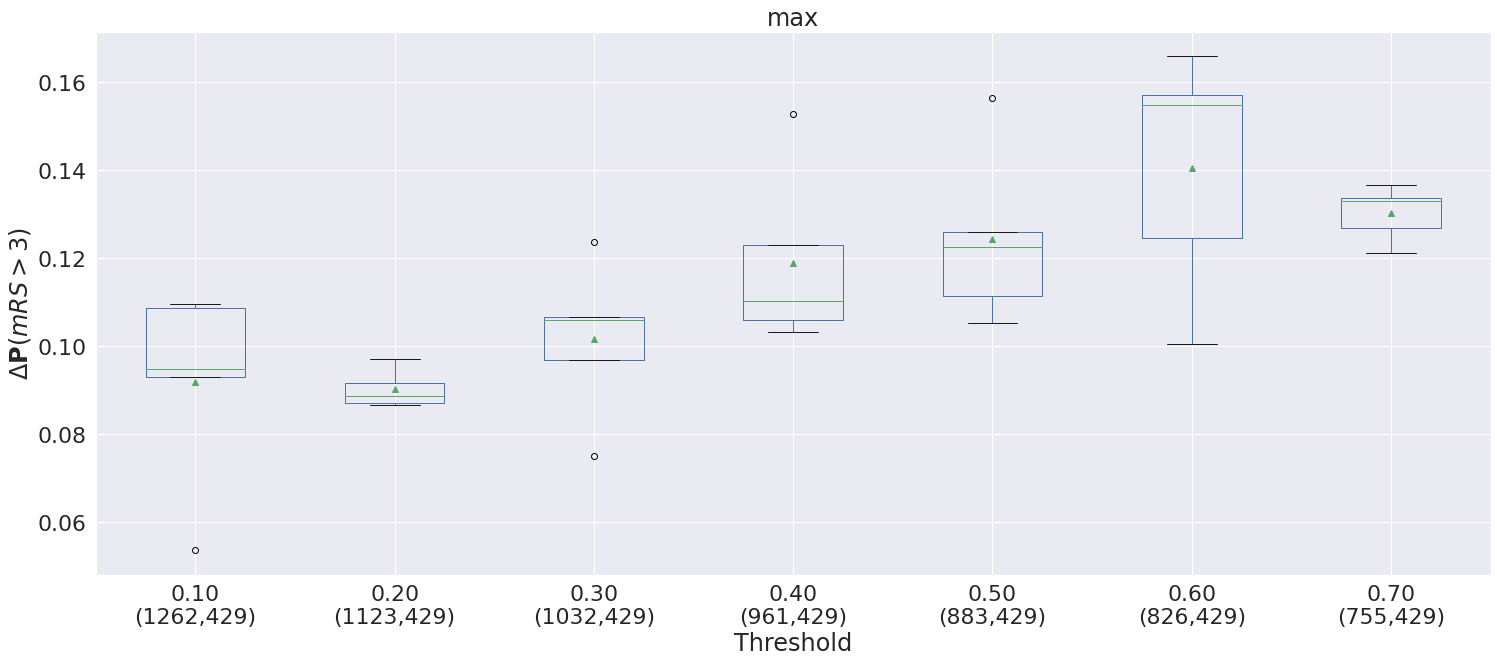

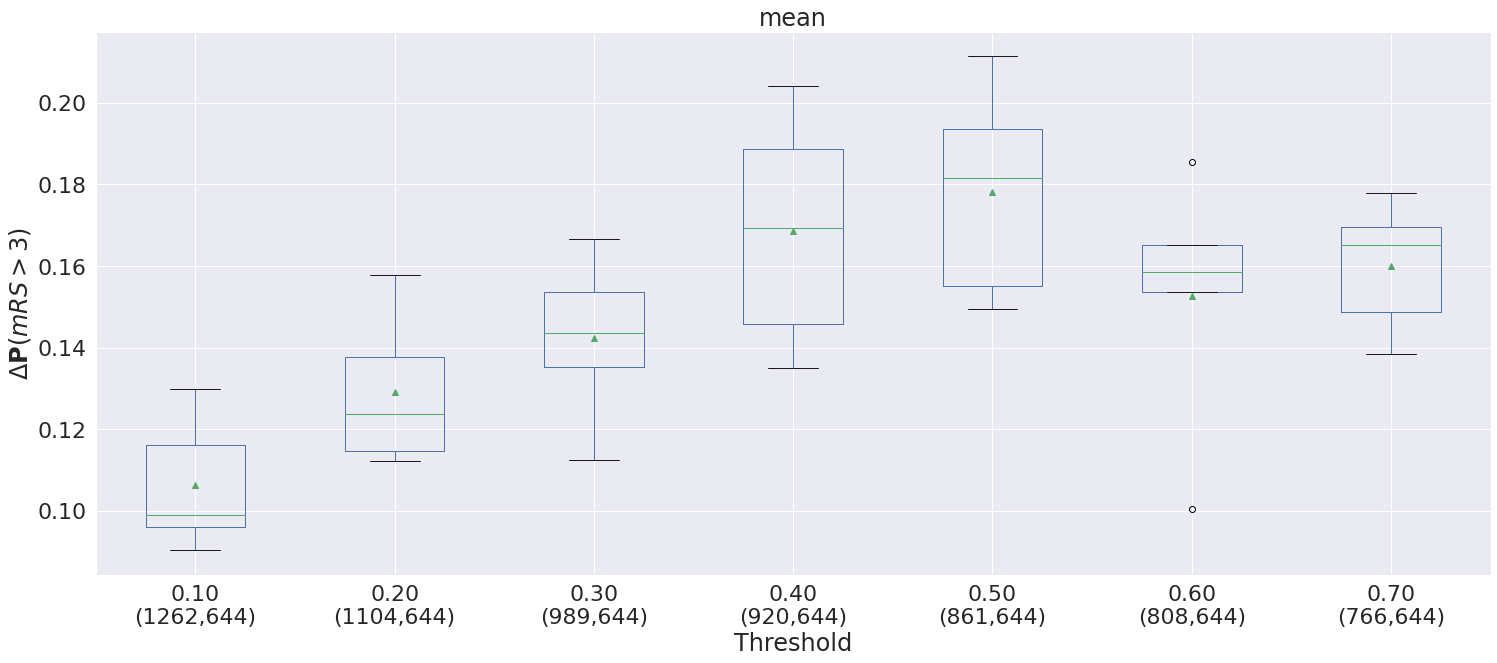

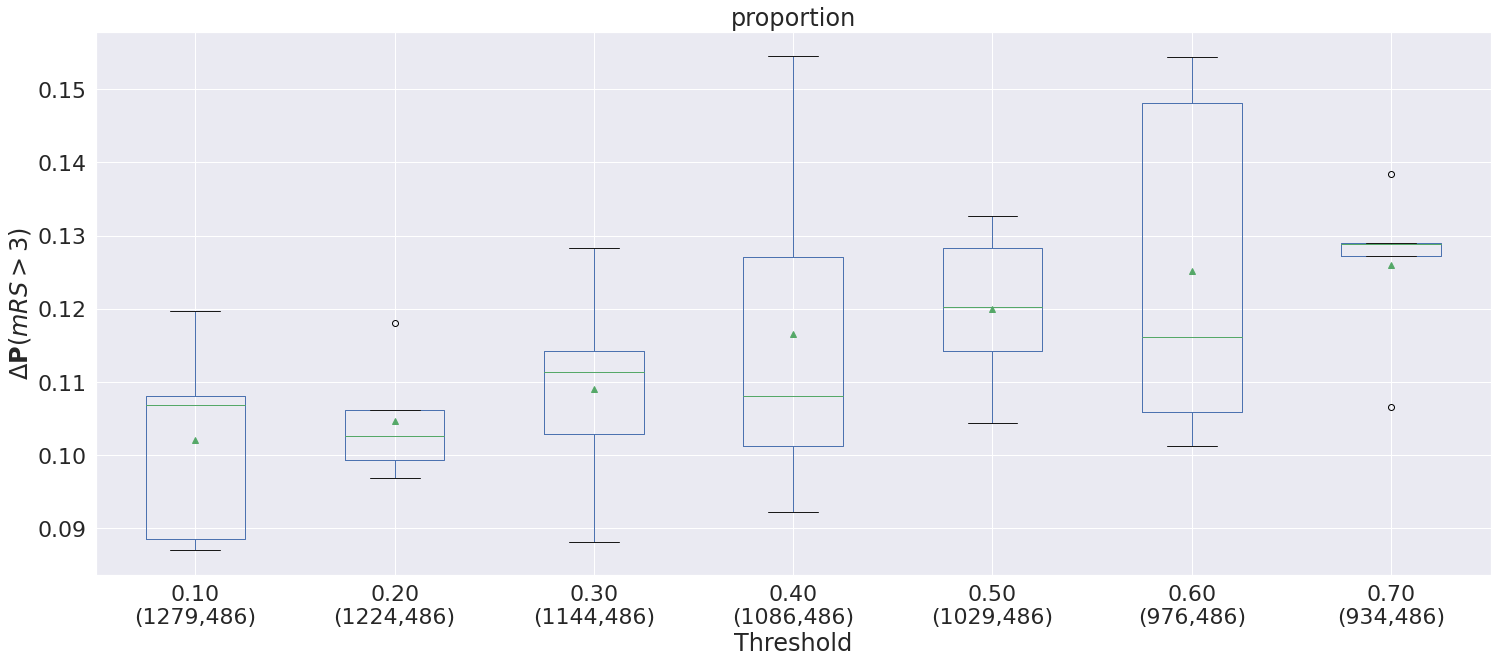

In [31]:
df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'iGCS-Total', 
                               'iGCS actual scores', 
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders', 
                               'mRS', 'E',
                               'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

m_dict = {}
baseline_threshold = 0.1
df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<baseline_threshold]

final_df = df_coarsen_baseline



for type_summary in tqdm.tqdm(['max','mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)

    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'iGCS-Total', 
                               'iGCS actual scores', 
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders', 
                               'mRS', 'E',
                               'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    m_dict = {}
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    num = []
    n_thresholds = 7
    for threshold in tqdm.tqdm(np.linspace(baseline_threshold,0.7,num=n_thresholds)):
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] >= threshold]
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        num_treated = df_malts.shape[0]
        df_malts['T'] = df_malts['E'] >= threshold
        df_malts.drop(columns=['mRS','E'],inplace=True)
        m = pm.malts_mf(outcome='Y',treatment='T',data=df_malts,n_repeats=1,n_splits=5,output_format='full')
        m_dict[threshold] = m
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        
        name = type_summary + str(threshold)
        final_df[name] = m.CATE_df['avg.CATE']

    ates = []
    for k,m in m_dict.items():
        ates.append(list(m.CATE_df.mean(axis=0)['CATE']))

    ate_df = pd.DataFrame(ates,index=np.round(np.linspace(baseline_threshold,0.8,num=n_thresholds),decimals=2))

    sns.set(font_scale=2)
    fig,ax = plt.subplots(figsize=(25,10))
    ate_df.T.plot(kind='box',ax=ax,showmeans=True,rot=0)
    # ate_df.mean(axis=1).plot(ax=ax)
    ax.set_ylabel('$\Delta \mathbf{P}(mRS>3)$')
    ax.set_xlabel('Threshold')
    ax.set_title(type_summary)
    ax.set_xticklabels(num)
    fig.savefig(type_summary+'.png')

In [33]:
final_df

,Gender,Age,marrital,Hx CVA (including TIA),Hx HTN,Hx Sz /epilepsy,Hx brain surgery,Hx CKD,Hx CAD/MI,Hx CHF,...,mean0.5,mean0.6,mean0.7,proportion0.1,proportion0.2,proportion0.3,proportion0.4,proportion0.5,proportion0.6,proportion0.7
3,1.0,23.08,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.181216,0.275187,0.389164,0.307926,0.296892,0.325451,0.367324,0.384843,0.187654,0.487198
8,1.0,79.08,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.087234,0.102189,-0.006462,0.049401,0.094710,0.150623,0.204386,0.236224,0.194137,0.119833
9,0.0,51.68,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.197095,0.232341,0.255205,0.104971,0.182380,0.144840,0.091847,0.075952,0.125448,0.129619
10,0.0,60.42,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.174972,0.239014,0.171835,0.062626,0.092067,0.164854,0.111842,0.152649,0.410564,0.275752
22,0.0,64.31,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.071727,-0.302235,-0.122200,0.049179,-0.004481,0.057993,0.129621,0.097168,0.048654,0.132134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,0.0,62.38,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.313298,0.226930,0.339024,0.135585,0.135387,0.083410,0.032629,0.098802,0.118218,0.143997
1302,1.0,76.52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.149647,0.114105,0.084397,-0.046647,0.156068,0.100023,0.061429,0.085972,0.026064,0.082195
1316,1.0,50.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.207169,0.034761,0.126478,0.058558,0.100872,-0.020732,0.123546,0.027101,0.075608,0.172838
1321,1.0,60.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.234739,0.080829,0.166793,0.045984,0.092508,0.072451,0.062645,0.110608,0.121438,0.068306


In [37]:
final_df.to_csv('CATES.csv', index=False)

# Short Term Drug Effect

In [9]:
frame = 25
df = setup_data(iic_burden,frame=frame)

100%|██████████| 1323/1323 [00:10<00:00, 129.26it/s]


In [343]:
short_term_df = df.loc[df['time_of_intervention']>0][['Gender', 'Age', 'marrital', 
                                                 'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                                                 'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF', 'Hx DM', 'Hx of HLD', 
                                                 'Hx tobacco (including ex-smokers)', 
                                                 'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                                                 'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)', 
                                                 'Hx CNS cancer', 'Hx COPD/ Asthma', 'premorbid MRS before admission  (modified ranking scale),before admission', 
                                                 'SZ at presentation,(exclude non-convulsive seizures) just if it is mentioned in MGH notes (the date is necessary, however,the date is the day of admission at MGH)',
                                                 'hydrocephalus  (either on admission or during hospital course)   QPID', 'iMV  (initial (on admission) mechanical ventilation)', 
                                                 'systolic BP', 'diastolic BP', 'Midline shift with any reason ( Document Date)', 'Primary systemic dx Sepsis/Shock', 
                                                 'iGCS-Total', 'iGCS = T?', 'iGCS-E', 'iGCS-V', 'iGCS-M', 'Worst GCS in 1st 24', 'Worst GCS Intubation status', 
                                                 'iGCS actual scores', 'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders', 
                                                 'time_of_intervention', 'drug_administered']+['iic_%d'%(i) for i in range(frame)]]


1. For each time of intervention
2. For each drug


Calculate the drug effect

In [346]:
def synthetic_control(units_ts,
                      treatments,
                      time_of_intervention,
                      effect_dict,
                      method='Lasso'):
    
    donors = units_ts.loc[treatments==0].drop(columns=['time_of_intervention'])
    targets = units_ts.loc[units_ts['time_of_intervention']==time_of_intervention].drop(columns=['time_of_intervention'])
    for idx in tqdm.tqdm(targets.index):
        y = targets.loc[idx]
        ypre = y[:time_of_intervention]
        if method=='Lasso':
            model = lm.LassoCV()
        if method=='Ridge':
            model = lm.RidgeCV()
        if method=='RF':
            model = en.RandomForestRegressor()
        if method=='Linear':
            model = lm.LinearRegression()
        model = model.fit(donors.to_numpy()[:,:time_of_intervention].T,ypre)
        y_hat = model.predict(donors.T.to_numpy())
        effect = pd.DataFrame([y.to_numpy().reshape(-1,) - y_hat.reshape(-1,)],
                              index=[idx],
                              columns=10*np.arange(-time_of_intervention+2,frame-time_of_intervention+2))
        effect_dict[treatments.loc[idx]] = effect_dict[treatments.loc[idx]].append(effect)
    return effect_dict

In [347]:
units_ts = short_term_df[['time_of_intervention']+['iic_%d'%(i) for i in range(frame)]].fillna(method='bfill').fillna(method='ffill').fillna(0)
treatments = short_term_df['drug_administered']
effect_dict = {treatment:pd.DataFrame() for treatment in treatments.unique()}
for time_of_intervention in range(10,20):
    effect_dict = synthetic_control(units_ts,treatments,time_of_intervention,effect_dict,method='Ridge')
    

100%|██████████| 5/5 [00:00<00:00, 282.84it/s]


<AxesSubplot:>

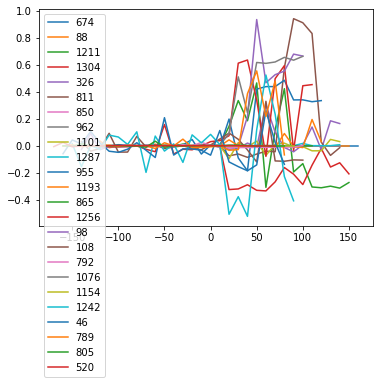

In [350]:
effect_dict['propofol'].T.plot(kind='line')

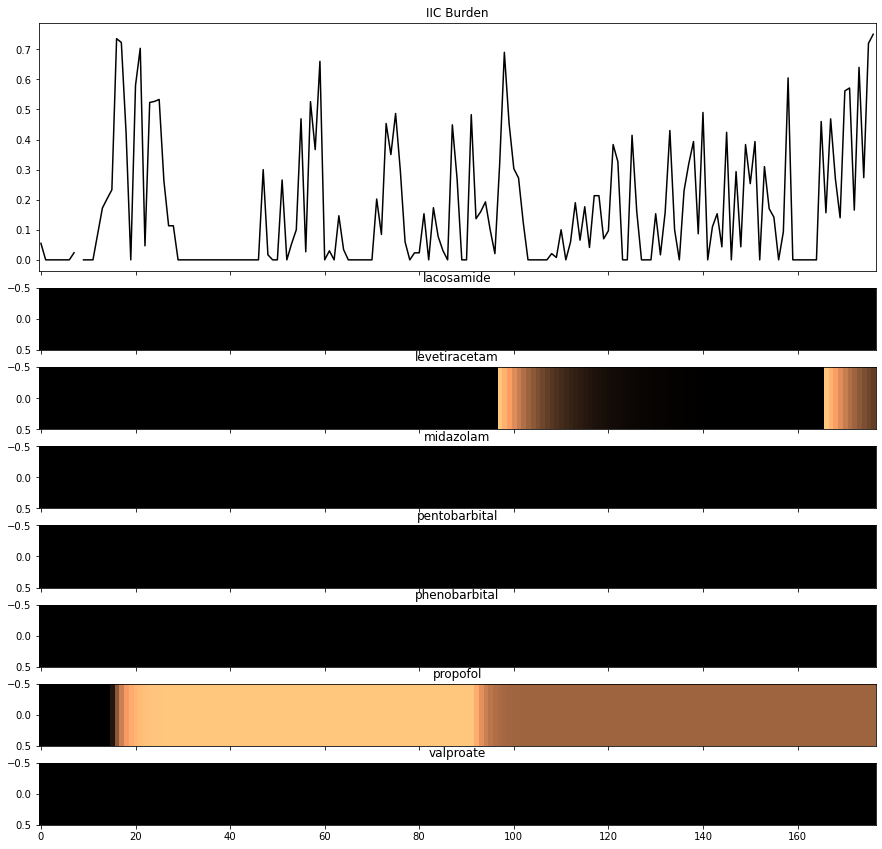

In [359]:
E = iic_burden['Pobs'][1256]
D = iic_burden['D'][1256]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

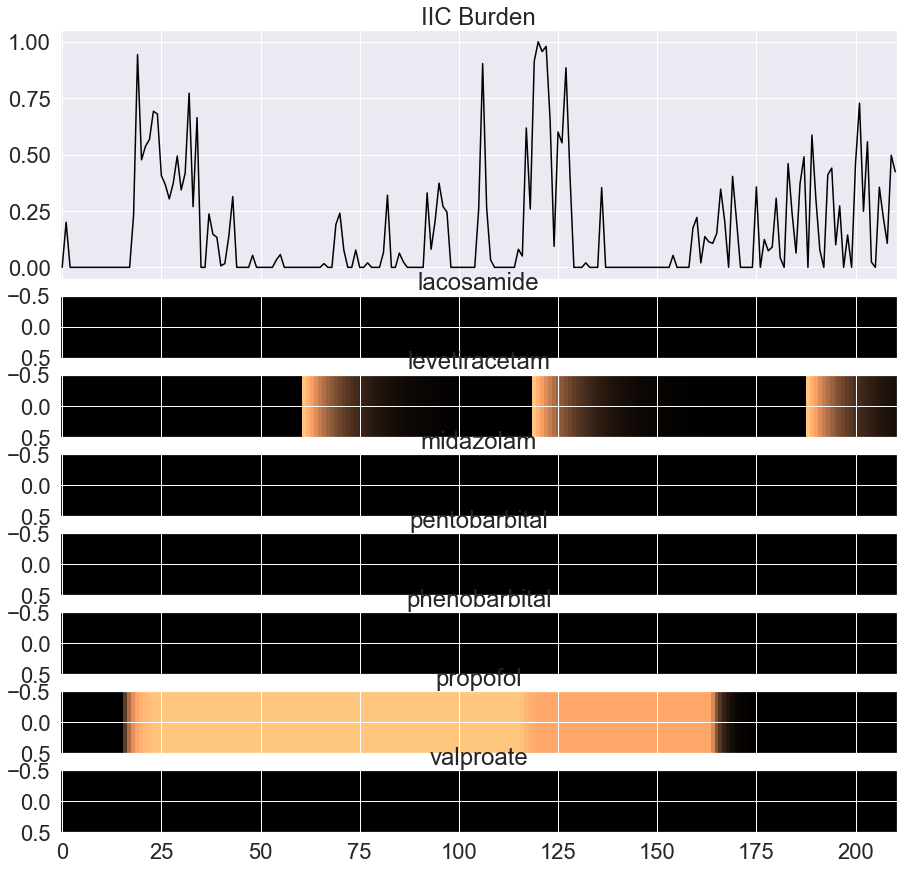

In [72]:
E = iic_burden['Pobs'][98]
D = iic_burden['D'][98]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

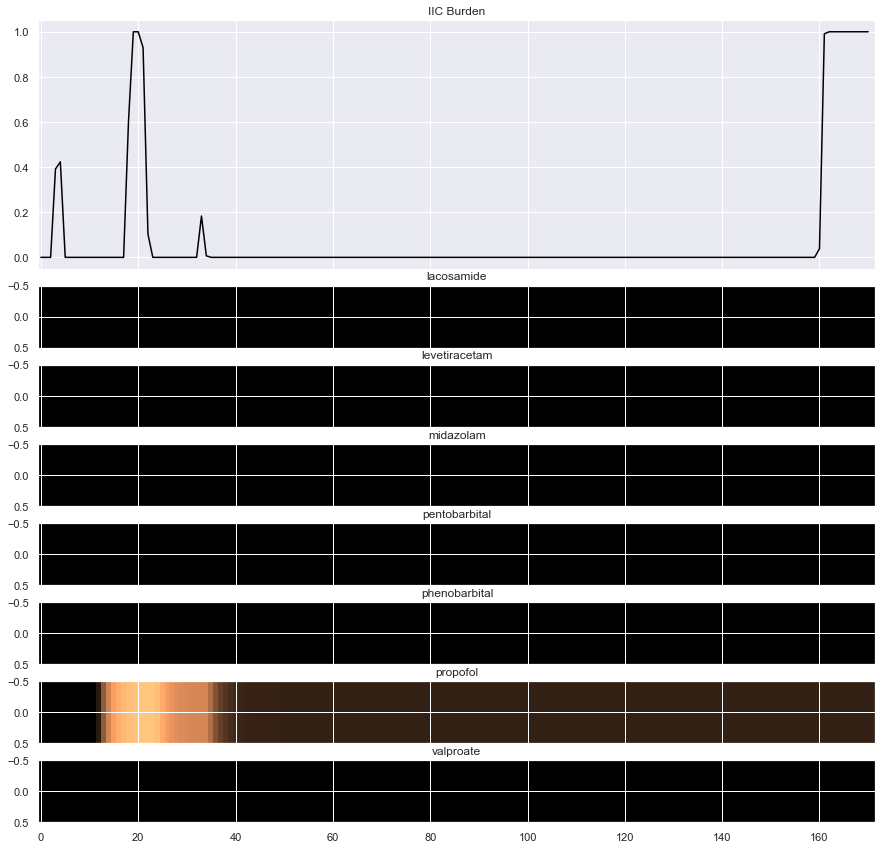

In [75]:
sns.set(font_scale=1)
E = iic_burden['Pobs'][811]
D = iic_burden['D'][811]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

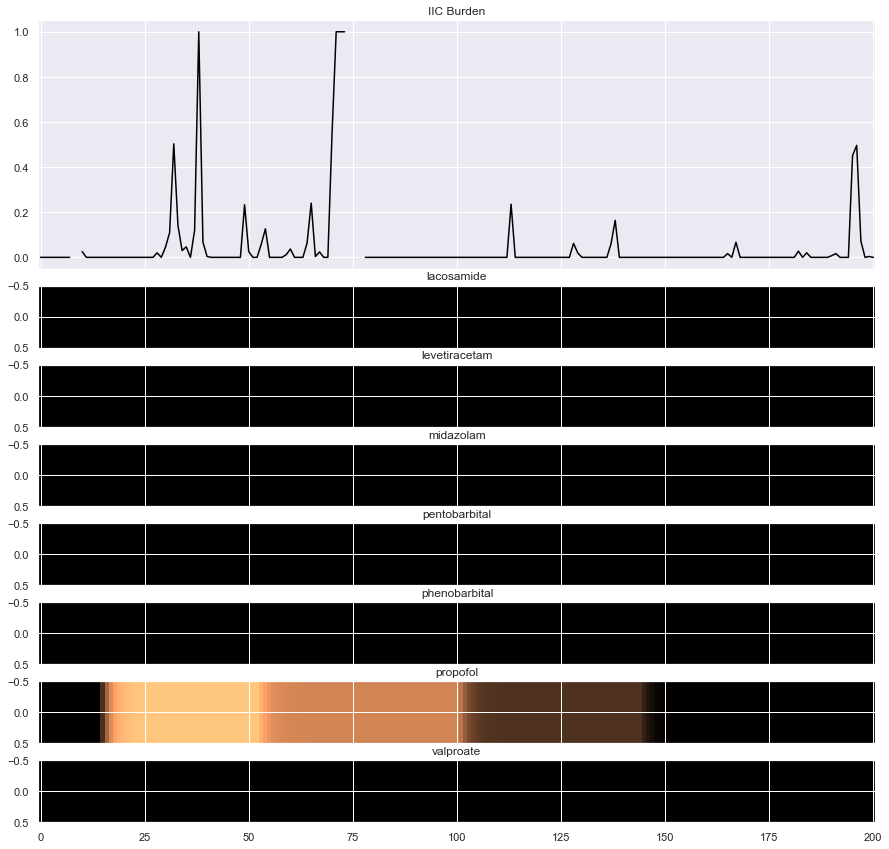

In [82]:
sns.set(font_scale=1)
E = iic_burden['Pobs'][865]
D = iic_burden['D'][865]
Dnames = iic_burden['Dname']
plot_unit(E,D,Dnames)

<AxesSubplot:>

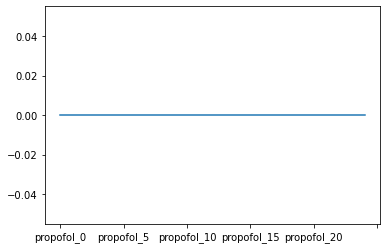

In [345]:
df.index[673]
df[['propofol_%d'%(i) for i in range(0,25)]].loc[673].plot(kind='line')

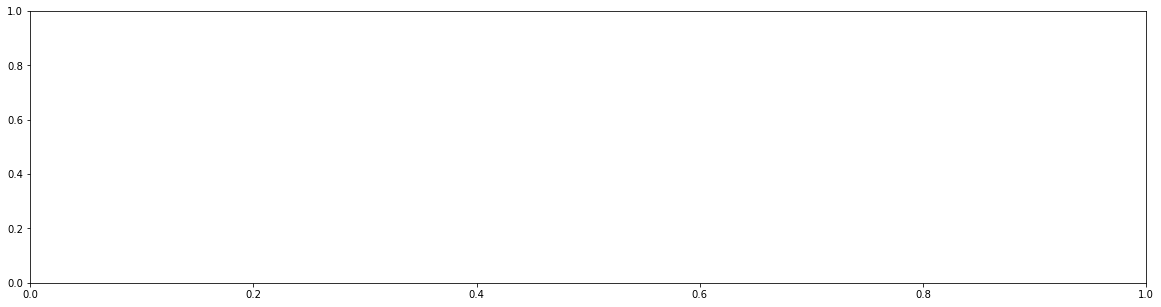

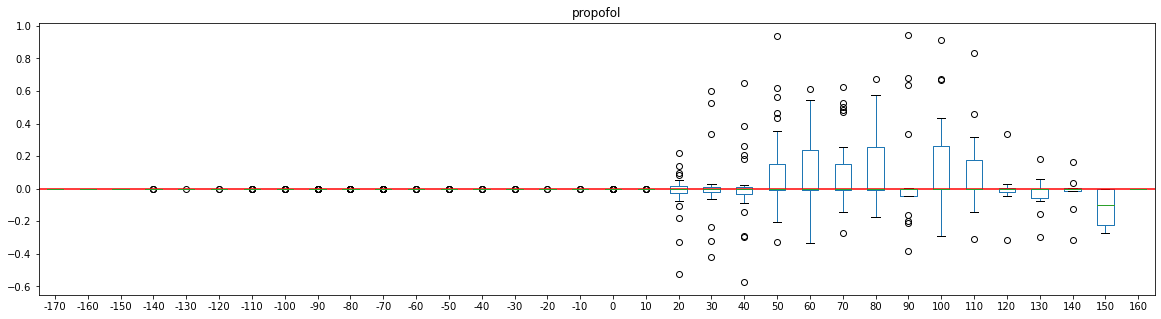

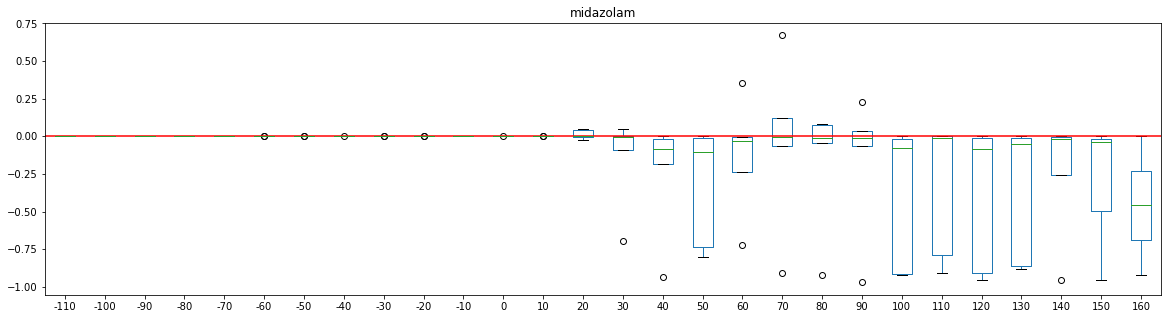

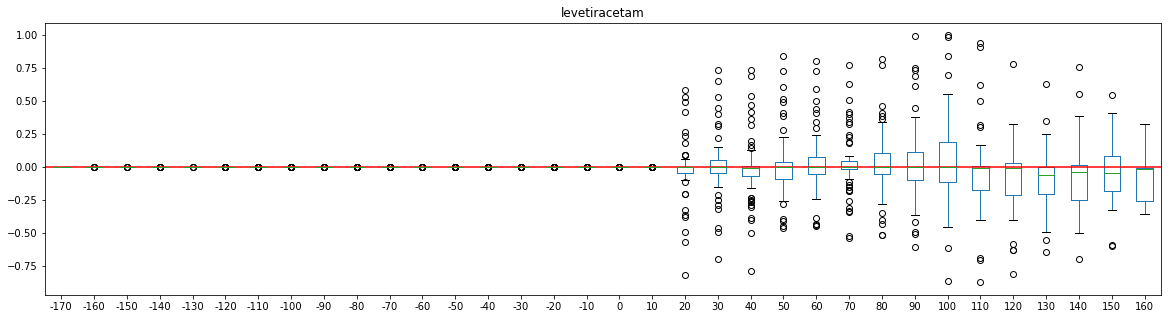

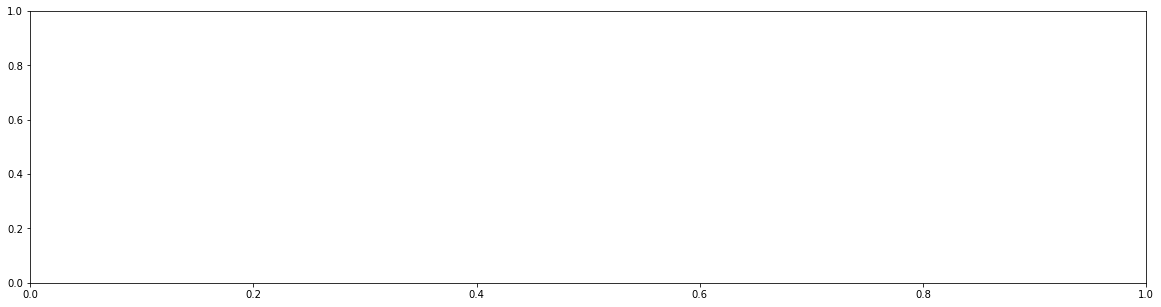

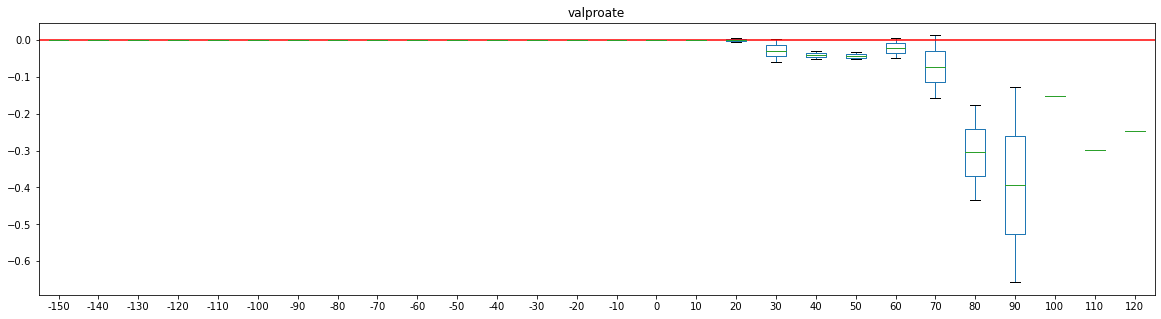

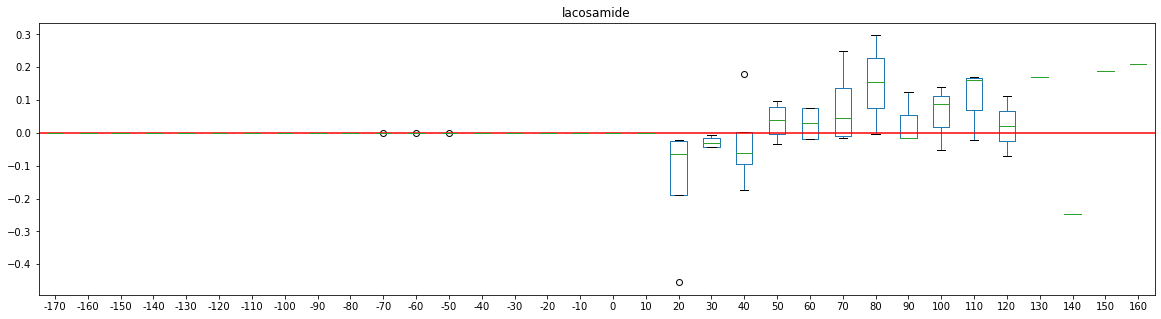

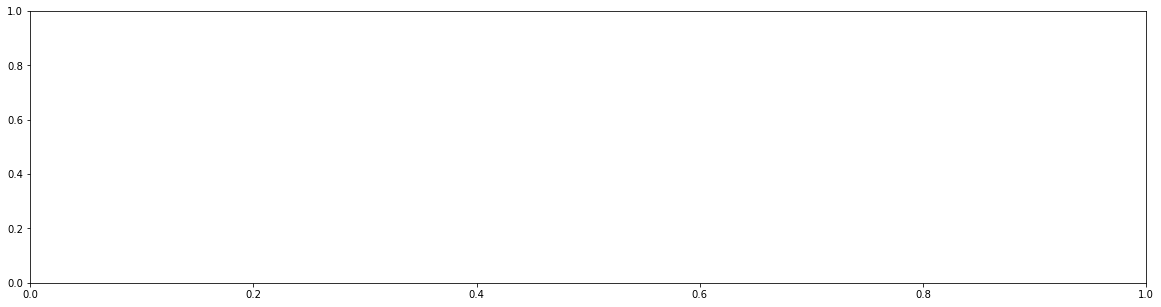

In [325]:
for treatment in treatments.unique():
    fig,ax = plt.subplots(figsize=(20,5))
    try:
        effect_dict[treatment].plot(kind='box',ax=ax)
    except:
        continue
#     plt.axvline(0,color='red')
    plt.axhline(0,color='red')
    plt.title(treatment)